In [ ]:
#Adi Gumelar_CV A_Batch 6

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
import tensorflow as tf

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
import matplotlib.image as mpimg
import plotly.express as px

import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import time
from torch.autograd import Variable
from torchvision.io import read_image

In [3]:
torch.cuda.is_available()

False

In [4]:
sns.set()
df_gender = pd.read_csv('drive/MyDrive/Colab Notebooks/gender_classification.csv')
df_gender

,Male
0,1
1,1
2,1
3,0
4,0
...,...
4995,0
4996,1
4997,1
4998,0


In [5]:
df_identity = pd.read_csv('drive/MyDrive/Colab Notebooks/class_identity.txt', sep=' ')
df_identity.set_index('image', inplace = True)
df_identity

,id
image,
000001.jpg,2880
000002.jpg,2937
000003.jpg,8692
000004.jpg,5805
000005.jpg,9295
...,...
202595.jpg,9761
202596.jpg,7192
202597.jpg,9852


In [6]:
df_attribute = pd.read_csv('drive/MyDrive/Colab Notebooks/list_attribute.txt', sep=' ', on_bad_lines='warn')
df_attribute.set_index('image', inplace = True)
df_attribute.replace(to_replace = -1, value = 0,inplace = True)
df_attribute

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [7]:
check_missing = df_attribute.isnull().sum()
check_missing = check_missing[check_missing > 0]
check_missing = check_missing.sort_values(ascending=True)
check_missing

,0


In [8]:
df_attribute.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,0.111136,0.266981,0.512505,0.204572,0.022443,0.151575,0.240796,0.234532,0.239251,0.147992,...,0.056511,0.48208,0.208402,0.319567,0.188925,0.048460,0.472436,0.122967,0.072715,0.773617
std,0.314301,0.442383,0.499845,0.403389,0.148121,0.358610,0.427568,0.423707,0.426627,0.355093,...,0.230906,0.49968,0.406167,0.466310,0.391450,0.214737,0.499241,0.328400,0.259669,0.418491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Plotting gender distribution pie plot of df_gender
labels = {1:'Male', 0:'Female'}
value_counts = df_gender['Male'].value_counts()
values = pd.DataFrame({'Male': value_counts.index, 'count': value_counts.values})
values['Gender'] = values['Male'].map(labels)
fig = px.pie(values, values = 'count', names = 'Gender', template = 'seaborn',
            title = 'Gender Distribution from df_gender')
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

In [10]:
# Plotting gender distribution pie plot of df_attribute
labels = {1:'Male', 0:'Female'}
value_counts = df_attribute['Male'].value_counts()
values = pd.DataFrame({'Male': value_counts.index, 'count': value_counts.values})
values['Gender'] = values['Male'].map(labels)
fig = px.pie(values, values = 'count', names = 'Gender', template = 'seaborn',
            title = 'Gender Distribution from df_attribute')
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

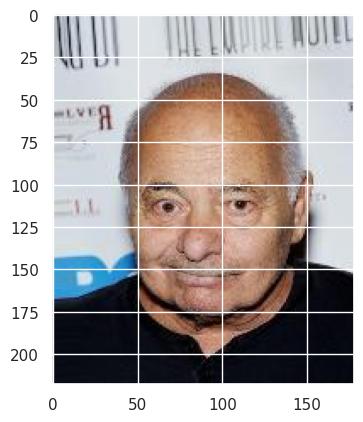

,000051.jpg
Male,1


In [11]:
# Test Displaying one of the picture in the dataset
img = mpimg.imread('drive/MyDrive/Colab Notebooks/Images/000051.jpg')
imgplot = plt.imshow(img)
plt.show()
df_attribute.loc["drive/MyDrive/Colab Notebooks/Images/000051.jpg".split('/')[-1]][['Male']]

In [12]:
arr_images = []
for x in df_attribute.index:
  if os.path.exists("drive/MyDrive/Colab Notebooks/Images/"+x):
    arr_images.append(x)

len(arr_images)

5000

In [13]:
df_attribute_fixed = df_attribute.loc[df_attribute.index.isin(arr_images)]
df_attribute_fixed

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image,,,,,,,,,,,,,,,,,,,,,
000051.jpg,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
000052.jpg,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
000065.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1
000166.jpg,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
000198.jpg,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202320.jpg,0,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1
202340.jpg,0,0,1,0,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,0,1
202347.jpg,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [14]:
# Check Plotting gender distribution pie plot of df_attribute_fixed
labels = {1:'Male', 0:'Female'}
value_counts = df_attribute_fixed['Male'].value_counts()
values = pd.DataFrame({'Male': value_counts.index, 'count': value_counts.values})
values['Gender'] = values['Male'].map(labels)
fig = px.pie(values, values = 'count', names = 'Gender', template = 'seaborn',
            title = 'Gender Distribution from df_attribute_fixed')
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

In [15]:
# Merging dataframes
df_attribute_merge = pd.merge(df_attribute_fixed, df_identity, left_index = True, right_index = True)
df_attribute_merge

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,id
image,,,,,,,,,,,,,,,,,,,,,
000051.jpg,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1446
000052.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,3896
000065.jpg,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,3046
000166.jpg,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4328
000198.jpg,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202320.jpg,0,1,0,0,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,1,9696
202340.jpg,0,0,1,0,0,0,0,0,1,0,...,1,1,0,0,0,1,0,0,1,8450
202347.jpg,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,7306


In [16]:
df_project = df_attribute_merge.reset_index()
df_project.drop(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'], axis=1, inplace=True)
df_project

,image,Male,id
0,000051.jpg,1,1446
1,000052.jpg,1,3896
2,000065.jpg,1,3046
3,000166.jpg,1,4328
4,000198.jpg,0,693
...,...,...,...
4995,202320.jpg,0,9696
4996,202340.jpg,0,8450
4997,202347.jpg,0,7306
4998,202357.jpg,0,9149


In [17]:
# split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(df_project, test_size=0.2, random_state=42)

In [18]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        # please define image convertion technique to RGB here
        #image = cv2.imread(image_path)
        #image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (100, 100)).astype(np.float32) / 255.0
        #image = np.expand_dims(image, axis =0)
        image = read_image(image_path)
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, gender #torch.tensor(gender, dtype=torch.long)

In [19]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
data_path = 'drive/MyDrive/Colab Notebooks'
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=train_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, image_folder_path=os.path.join(data_path, "Images"), transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

ResNet

In [21]:
# please define the model optimizer and criterion (loss function)
model = models.resnet50()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning:

The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.



In [22]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, num_epochs=1):
    # please define the training model (VGG/GoogleNet/ResNet) here
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)


                # backward + optimize only if in training phase
                if phase == 'train':
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'drive/MyDrive/Colab Notebooks/point_resnet_best_calculate.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
    #pass

In [23]:
dataloders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

In [24]:
use_gpu = torch.cuda.is_available()

In [25]:
model = train_model(model, dataloders, dataset_sizes, criterion, optimizer, use_gpu, 1)

Epoch 0/0
----------
train Loss: 0.0826 Acc: 0.5913
test Loss: 0.0211 Acc: 0.6920

Training complete in 26m 25s
Best test Acc: 0.692000


In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
def visualize_model(model, test_loader, target_labels, use_gpu=torch.cuda.is_available()):
    images_so_far = 0
    fig = plt.figure()
    class_names = test_loader.classes

    for i, data in enumerate(test_loader):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.logits, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            #images_so_far += 1
            #ax = plt.subplot(num_images//2, 2, images_so_far)
            #ax.axis('off')
            #ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            print('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            #if images_so_far == num_images:
                #return
    #pass

In [52]:
def evaluate_model(model, test_loader, target_labels, use_gpu=torch.cuda.is_available()):
    CM=0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            # wrap them in Variable
            if use_gpu:
              inputs = Variable(inputs.cuda())
              labels = Variable(labels.cuda())
            else:
              inputs, labels = Variable(inputs), Variable(labels)

            outputs = model(inputs) #file_name
            preds = torch.argmax(outputs.data, 1)
            CM+=confusion_matrix(labels, preds)

        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)

        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print()
        print('Confusion Matrix : ')
        print(CM)
        print('- Accuracy : ', acc)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
        print()

        # Plot the confusion matrix
        plt.imshow(CM, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.rcParams["axes.grid"] = False
        plt.xticks(tick_marks, ['Class 0', 'Class 1'])
        plt.yticks(tick_marks, ['Class 0', 'Class 1'])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # Add labels to the plot
        width, height = CM.shape
        for x in range(width):
            for y in range(height):
                plt.annotate(str(CM[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

        plt.show()

        print(classification_report(labels, preds))
    #return acc, CM
    #pass


Testset Accuracy(mean): 69.200000 %

Confusion Matrix : 
[[436 160]
 [148 256]]
- Accuracy :  0.692
- Sensitivity :  63.366336633663366
- Specificity :  73.15436241610739
- Precision:  61.53846153846154
- NPV:  74.65753424657534
- F1 :  62.439024390243894



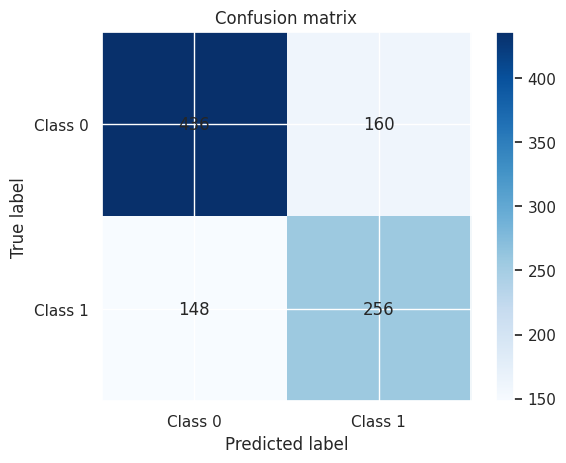

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.75      0.60      0.67         5

    accuracy                           0.62         8
   macro avg       0.62      0.63      0.62         8
weighted avg       0.66      0.62      0.63         8



In [53]:
evaluate_model(model, dataloders['test'], ["female", "male"])